In [79]:
import control as ctrl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import sympy as sp

In [80]:
plt.style.use(plt.style.available[9])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [81]:
class DeepNetwork(torch.nn.Module):
    def __init__(self, input_dim=8, hidden_dims=[128, 128, 128], num_classes=5):
        super(DeepNetwork, self).__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        
        # Build the hidden layers
        for i in range(len(dims) - 1):
            layers.append(torch.nn.Linear(dims[i], dims[i + 1]))
            layers.append(torch.nn.Sigmoid())
        
        # Output layer
        layers.append(torch.nn.Linear(dims[-1], num_classes))
        
        # Sequentially stack the layers
        self.model = torch.nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [82]:
numerator = [40]
denominator = [1, 1]
H_s = ctrl.tf(numerator,denominator)
H_s

TransferFunction(array([40]), array([1, 1]))

In [83]:
# Function to normalize the output
def normalize_signal(signal):
    # return (signal - np.min(signal)) / (np.max(signal) - np.min(signal))
    return signal

# Function to generate diverse input signals and their system responses
def generate_datasets_with_signal_types(num_samples=5000, duration=10, step=True, exp=True, sin=False, squ=False, rand=True):
    np.random.seed(9496159)
    time = np.linspace(0, duration, num_samples)
    datasets = []

    # Step input
    if step:
        step_input = np.ones(num_samples)
        T, y_step = ctrl.forced_response(H_s, T=time, U=step_input)
        datasets.append((time, step_input, normalize_signal(y_step)))

    # Exponential input
    if exp:
        exp_input = np.exp(-0.5 * time)
        T, y_exp = ctrl.forced_response(H_s, T=time, U=exp_input)
        datasets.append((time, exp_input, normalize_signal(y_exp)))

    # Sinusoidal input
    if sin:
        sin_input = np.sin(2 * np.pi * 0.5 * time)
        T, y_sin = ctrl.forced_response(H_s, T=time, U=sin_input)
        datasets.append((time, sin_input, normalize_signal(y_sin)))

    # Square wave input
    if squ:
        square_input = np.sign(np.sin(2 * np.pi * 0.5 * time))
        T, y_square = ctrl.forced_response(H_s, T=time, U=square_input)
        datasets.append((time, square_input, normalize_signal(y_square)))

    # Random noise input
    if rand:
        # np.random.seed(42)
        random_input = np.random.rand(num_samples)
        T, y_random = ctrl.forced_response(H_s, T=time, U=random_input)
        datasets.append((time, random_input, normalize_signal(y_random)))

    return datasets

# Generate datasets
datasets = generate_datasets_with_signal_types()

In [84]:
# Assuming `datasets` contains the generated data
all_inputs = []
all_outputs = []

# Combine all datasets
for time, input_signal, y_out in datasets:
    all_inputs.append(input_signal)
    all_outputs.append(y_out)

# Concatenate all datasets into single arrays
all_inputs = np.concatenate(all_inputs)
all_outputs = np.concatenate(all_outputs)

# Prepare data for PyTorch
y = torch.from_numpy(all_inputs).reshape(-1, 1).to(device).float()  # Input signals
X = torch.from_numpy(all_outputs).reshape(-1, 1).to(device).float()  # System outputs

# Model definition
model = DeepNetwork(input_dim=X.shape[1], hidden_dims=[64], num_classes=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X)  # Model predictions
    loss = criterion(outputs, y)  # Compute loss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Log progress every 5000 epochs
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 1.3102411031723022
Epoch 500, Loss: 0.05726903676986694


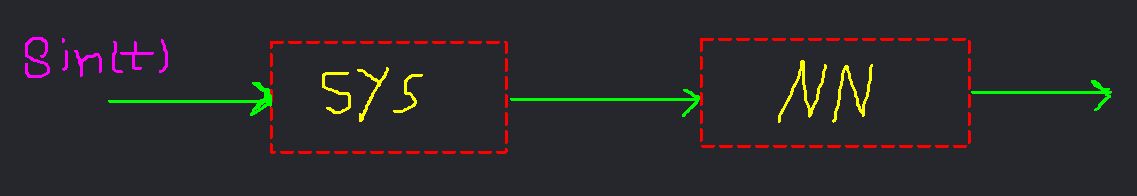

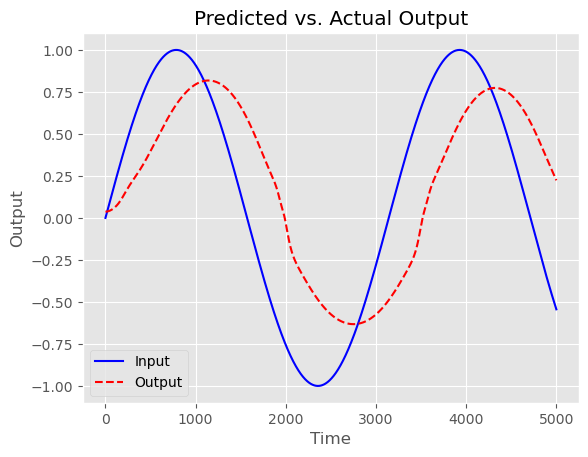

In [85]:
input_test = np.sin(time)

T, y_test = ctrl.forced_response(H_s, T=time, U=input_test)

# y_test = (y_test - np.min(y_test)) / (np.max(y_test) - np.min(y_test))
X = torch.from_numpy(y_test).reshape(-1,1).to(device).float()

out = model(X)


plt.plot(input_test, label="Input", color="blue")
plt.plot(out.detach().cpu().numpy(), label="Output", color="red", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Output")
plt.legend()
plt.title("Predicted vs. Actual Output")
plt.show()

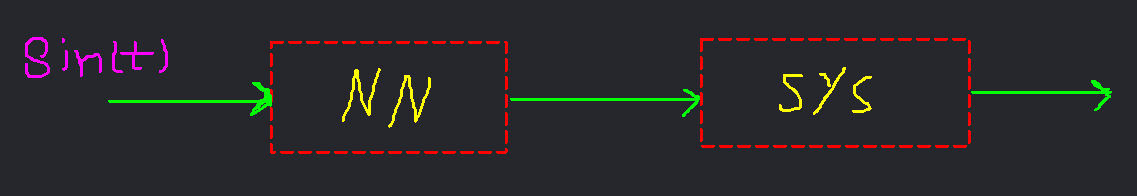

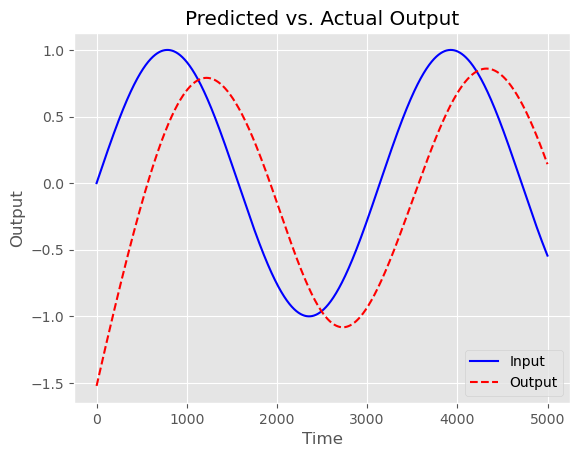

In [86]:
input_test = np.sin(time)

X = torch.from_numpy(input_test).to(device).float().reshape(-1, 1)

out = model(X)

T, y_test = ctrl.forced_response(H_s, T=time, U=out.detach().reshape(-1,).cpu().numpy())
y_test = y_test - np.mean(y_test)

plt.plot(input_test, label="Input", color="blue")
plt.plot(y_test, label="Output", color="red", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Output")
plt.legend()
plt.title("Predicted vs. Actual Output")
plt.show()

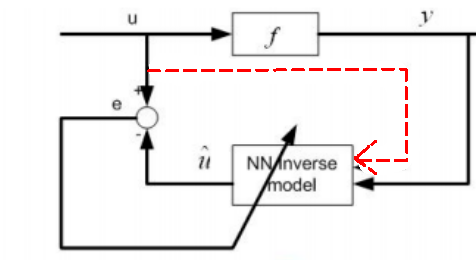

In [87]:
# Example white noise input signal
torch.manual_seed(42)
input_signal = np.random.rand(5000)
time = np.arange(0, 10, 0.002)

# Generate system response using control library
T, y_out = ctrl.forced_response(H_s, T=time, U=input_signal)
y_out = (y_out - np.min(y_out)) / (np.max(y_out) - np.min(y_out))

print(f'input_signal shape: {input_signal.shape}')
print(f'ouput signal shape: {y_out.shape}')

input_signal shape: (5000,)
ouput signal shape: (5000,)


In [88]:
y = torch.from_numpy(input_signal).reshape(-1, 1).to(device).float()
x = torch.from_numpy(y_out).reshape(-1, 1).to(device).float()
X = torch.cat([x, y], dim=1)

model = DeepNetwork(input_dim=X.shape[1], hidden_dims=[256], num_classes=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    if epoch %5000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.6436315178871155
Epoch 5000, Loss: 6.253355422813911e-06


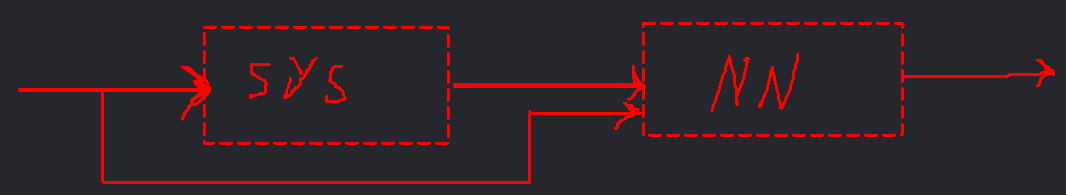

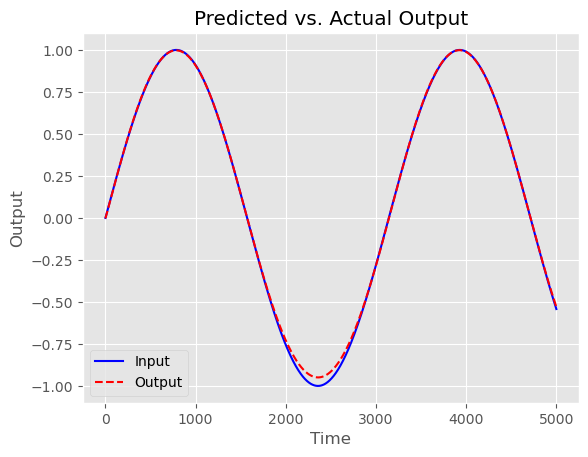

In [89]:
input_test = np.sin(time)

T, y_test = ctrl.forced_response(H_s, T=time, U=input_test)

y_test = (y_test - np.min(y_test)) / (np.max(y_test) - np.min(y_test))
y = torch.from_numpy(y_test).reshape(-1,1).to(device).float()
x = torch.from_numpy(input_test).to(device).float().reshape(-1, 1)

X = torch.cat([y, x], dim=1)

out = model(X)


plt.plot(input_test, label="Input", color="blue")
plt.plot(out.detach().cpu().numpy(), label="Output", color="red", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Output")
plt.legend()
plt.title("Predicted vs. Actual Output")
plt.show()

# Practice 1

In [90]:
numerator = [1]
denominator = [1, -1]
H_s = ctrl.tf(numerator,denominator)
H_s

TransferFunction(array([1]), array([ 1, -1]))

In [91]:
# Assuming `datasets` contains the generated data
all_inputs = []
all_outputs = []

# Combine all datasets
for time, input_signal, y_out in datasets:
    all_inputs.append(input_signal)
    all_outputs.append(y_out)

# Concatenate all datasets into single arrays
all_inputs = np.concatenate(all_inputs)
all_outputs = np.concatenate(all_outputs)

# Prepare data for PyTorch
y = torch.from_numpy(all_inputs).reshape(-1, 1).to(device).float()  # Input signals
X = torch.from_numpy(all_outputs).reshape(-1, 1).to(device).float()  # System outputs

# Model definition
model = DeepNetwork(input_dim=X.shape[1], hidden_dims=[32], num_classes=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X)  # Model predictions
    loss = criterion(outputs, y)  # Compute loss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Log progress every 5000 epochs
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")


Epoch 0, Loss: 0.661279022693634
Epoch 500, Loss: 0.05715217813849449


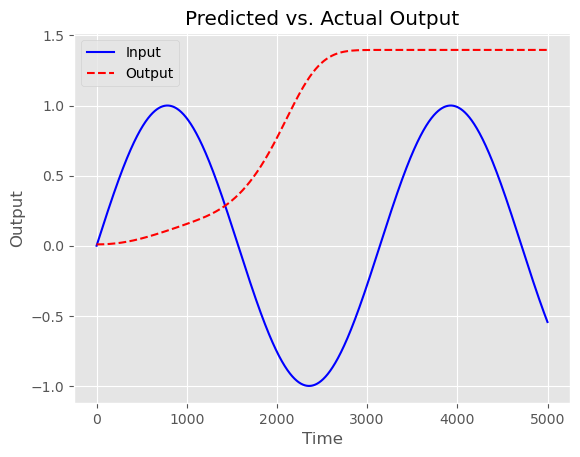

In [92]:
input_test = np.sin(time)

T, y_test = ctrl.forced_response(H_s, T=time, U=input_test)

# y_test = (y_test - np.min(y_test)) / (np.max(y_test) - np.min(y_test))
X = torch.from_numpy(y_test).reshape(-1,1).to(device).float()

out = model(X)


plt.plot(input_test, label="Input", color="blue")
plt.plot(out.detach().cpu().numpy(), label="Output", color="red", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Output")
plt.legend()
plt.title("Predicted vs. Actual Output")
plt.show()

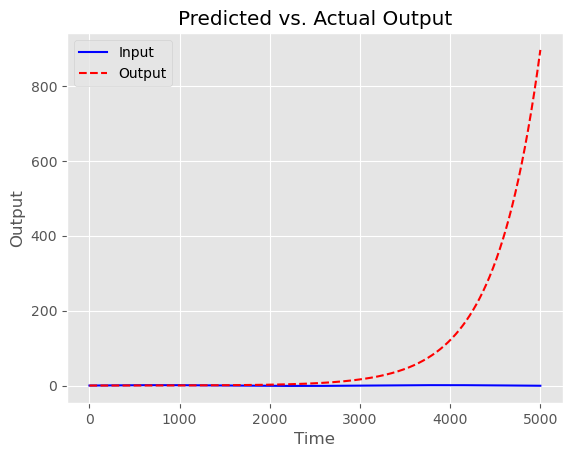

In [93]:
input_test = np.sin(time)

X = torch.from_numpy(input_test).to(device).float().reshape(-1, 1)

out = model(X)

T, y_test = ctrl.forced_response(H_s, T=time, U=out.detach().reshape(-1,).cpu().numpy())

plt.plot(input_test, label="Input", color="blue")
plt.plot(y_test, label="Output", color="red", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Output")
plt.legend()
plt.title("Predicted vs. Actual Output")
plt.show()

به دلیل ناپایداری ذاتی سیستم که ناشی از قطب سمت راست است. نمیتوان این سیستم را کنترل کرد.

# Practice 2

In [94]:
numerator = [1, 1]
denominator = [1, 5, 6]
H_s = ctrl.tf(numerator,denominator)
H_s

TransferFunction(array([1, 1]), array([1, 5, 6]))

In [95]:
datasets = generate_datasets_with_signal_types(exp=False, rand=False)

In [96]:
# Assuming `datasets` contains the generated data
all_inputs = []
all_outputs = []

# Combine all datasets
for time, input_signal, y_out in datasets:
    all_inputs.append(input_signal)
    all_outputs.append(y_out)

# Concatenate all datasets into single arrays
all_inputs = np.concatenate(all_inputs)
all_outputs = np.concatenate(all_outputs)

# Prepare data for PyTorch
y = torch.from_numpy(all_inputs).reshape(-1, 1).to(device).float()  # Input signals
X = torch.from_numpy(all_outputs).reshape(-1, 1).to(device).float()  # System outputs

# Model definition
model = DeepNetwork(input_dim=X.shape[1], hidden_dims=[32], num_classes=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X)  # Model predictions
    loss = criterion(outputs, y)  # Compute loss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Log progress every 5000 epochs
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.45146483182907104
Epoch 500, Loss: 3.232054268664797e-06


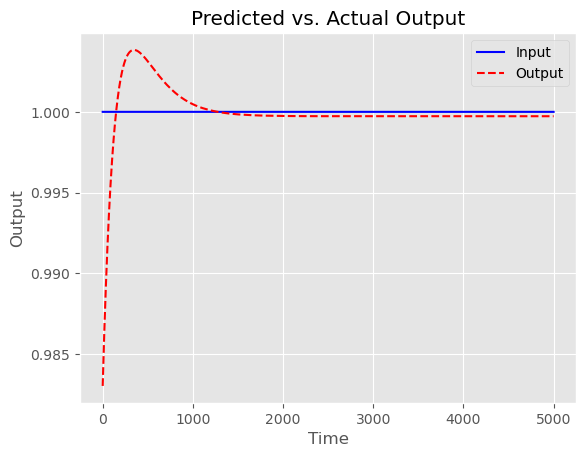

In [97]:
input_test = all_inputs

T, y_test = ctrl.forced_response(H_s, T=time, U=input_test)

# y_test = (y_test - np.min(y_test)) / (np.max(y_test) - np.min(y_test))
X = torch.from_numpy(y_test).reshape(-1,1).to(device).float()

out = model(X)


plt.plot(input_test, label="Input", color="blue")
plt.plot(out.detach().cpu().numpy(), label="Output", color="red", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Output")
plt.legend()
plt.title("Predicted vs. Actual Output")
plt.show()

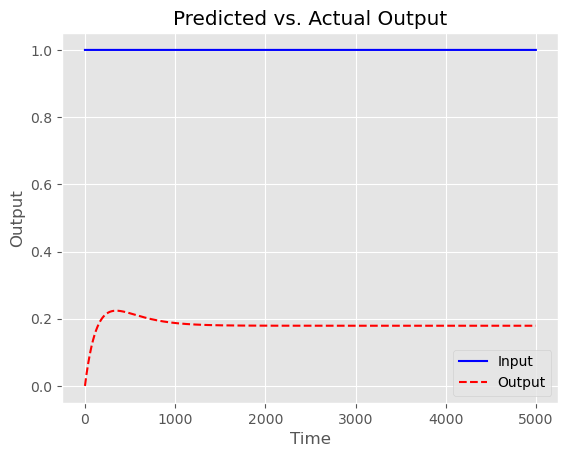

In [98]:
input_test = all_inputs

X = torch.from_numpy(input_test).to(device).float().reshape(-1, 1)

out = model(X)

T, y_test = ctrl.forced_response(H_s, T=time, U=out.detach().reshape(-1,).cpu().numpy())

plt.plot(input_test, label="Input", color="blue")
plt.plot(y_test, label="Output", color="red", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Output")
plt.legend()
plt.title("Predicted vs. Actual Output")
plt.show()

### add noise to X

In [99]:
# Assuming `datasets` contains the generated data
all_inputs = []
all_outputs = []

# Combine all datasets
for time, input_signal, y_out in datasets:
    all_inputs.append(input_signal)
    all_outputs.append(y_out)

# Concatenate all datasets into single arrays
all_inputs = np.concatenate(all_inputs)
all_outputs = np.concatenate(all_outputs)

# Prepare data for PyTorch
y = torch.from_numpy(all_inputs).reshape(-1, 1).to(device).float()  # Input signals
X_clean = torch.from_numpy(all_outputs).reshape(-1, 1).to(device).float()  # Clean system outputs

# Model definition
model = DeepNetwork(input_dim=X_clean.shape[1], hidden_dims=[32], num_classes=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Noise parameters
noise_level = 0.5  # Adjust this value to control noise intensity

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    # Add noise to X dynamically in each epoch
    noise = noise_level * torch.randn_like(X_clean).to(device)  # Generate noise
    X_noisy = X_clean + noise  # Add noise to X

    optimizer.zero_grad()
    outputs = model(X_noisy)  # Model predictions using noisy X
    loss = criterion(outputs, y)  # Compute loss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Log progress every 500 epochs
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")


Epoch 0, Loss: 0.6050747632980347
Epoch 500, Loss: 2.824574494297849e-06


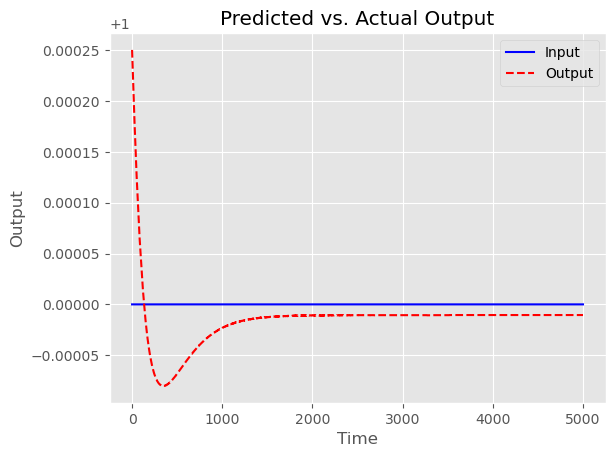

In [100]:
input_test = all_inputs

T, y_test = ctrl.forced_response(H_s, T=time, U=input_test)

# y_test = (y_test - np.min(y_test)) / (np.max(y_test) - np.min(y_test))
X = torch.from_numpy(y_test).reshape(-1,1).to(device).float()

out = model(X)


plt.plot(input_test, label="Input", color="blue")
plt.plot(out.detach().cpu().numpy(), label="Output", color="red", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Output")
plt.legend()
plt.title("Predicted vs. Actual Output")
plt.show()


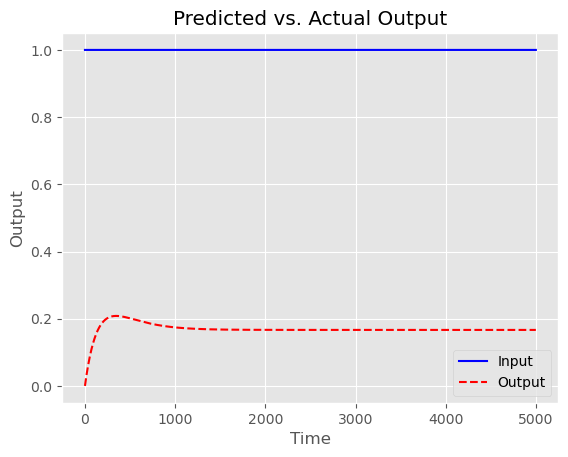

In [101]:
input_test = all_inputs

X = torch.from_numpy(input_test).to(device).float().reshape(-1, 1)

out = model(X)

T, y_test = ctrl.forced_response(H_s, T=time, U=out.detach().reshape(-1,).cpu().numpy())

plt.plot(input_test, label="Input", color="blue")
plt.plot(y_test, label="Output", color="red", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Output")
plt.legend()
plt.title("Predicted vs. Actual Output")
plt.show()

### add noise to input_signal

In [102]:
# np.random.seed(9496159)
step_input = np.ones(5000)
time = np.linspace(0, 10, 5000)
T, y_step = ctrl.forced_response(H_s, T=time, U=step_input)

model = DeepNetwork(input_dim=X.shape[1], hidden_dims=[256], num_classes=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X = torch.from_numpy(y_step).reshape(-1, 1).to(device).float()
y = torch.from_numpy(step_input).reshape(-1, 1).to(device).float()

# Noise parameters
noise_level = 0.5

# Training loop
num_epochs = 10000
for epoch in range(num_epochs):

    # Add noise to X dynamically in each epoch
    noise = noise_level * torch.randn_like(y).to(device)  # Generate noise
    y = y + noise  # Add noise to X
    
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    if epoch %5000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 1.7302519083023071
Epoch 5000, Loss: 1217.401123046875


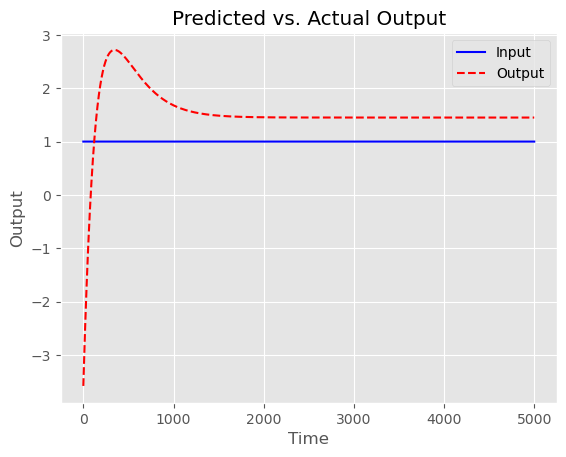

In [103]:
input_test = step_input

T, y_test = ctrl.forced_response(H_s, T=time, U=input_test)

# y_test = (y_test - np.min(y_test)) / (np.max(y_test) - np.min(y_test))
X = torch.from_numpy(y_test).reshape(-1,1).to(device).float()

out = model(X)


plt.plot(input_test, label="Input", color="blue")
plt.plot(out.detach().cpu().numpy(), label="Output", color="red", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Output")
plt.legend()
plt.title("Predicted vs. Actual Output")
plt.show()

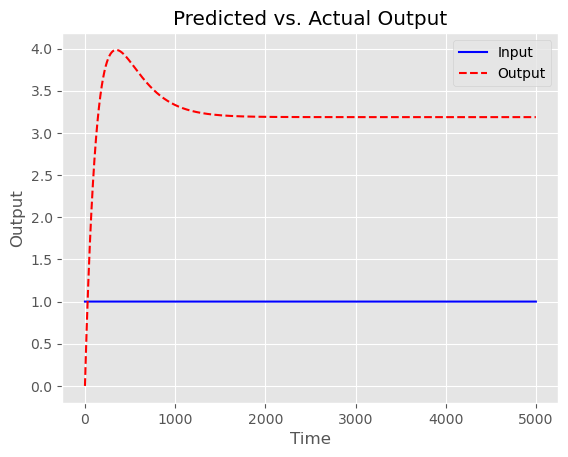

In [104]:
input_test = step_input

X = torch.from_numpy(input_test).to(device).float().reshape(-1, 1)

out = model(X)

T, y_test = ctrl.forced_response(H_s, T=time, U=out.detach().reshape(-1,).cpu().numpy())

plt.plot(input_test, label="Input", color="blue")
plt.plot(y_test, label="Output", color="red", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Output")
plt.legend()
plt.title("Predicted vs. Actual Output")
plt.show()

مشاهده میشود که با اضافه کردن نویز به در هر دو حالت، خروجی از خروجی مطلوب فاصله می‌گیرد.